In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors2
import matplotlib.cm as cmx
import matplotlib.mlab as mlab
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import math
import seaborn as sns
from six.moves import cPickle as pickle
import csv
import sys
import pandas as pd
import networkx as nx

import numpy.polynomial.polynomial as poly
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy import stats

import matplotlib.lines as mlines

from pyemd import emd
# https://github.com/wmayner/pyemd
# Ofir Pele and Michael Werman, "Fast and robust earth mover's distances," in Proc. 2009 IEEE 
# 12th Int. Conf. on Computer Vision, Kyoto, Japan, 2009, pp. 460-467.

%matplotlib inline
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', \
               'xtick.minor.size': 3.0, 'ytick.minor.size': 3.0, 'grid.linewidth': 0.})


In [2]:
# load the data
consumption_df = pd.read_pickle('../cleanedLoadData/consumption_df_round3.pickle')

In [3]:
print('There are now', len(consumption_df), 'users')

There are now 255 users


In [4]:
cIDs = consumption_df.user_id.unique()

In [5]:
consumption_df = consumption_df.set_index('user_id')

In [6]:
min15_df = consumption_df.iloc[:,2:]

In [7]:
min15Vals = min15_df.iloc[:,:].values

In [10]:
# change the vals to hourly
[a,b] = np.shape(min15Vals)
hourlyVals = np.zeros((a,int(b/4)))
for j in range(int(b/4)):
    hourlyVals[:,j] = np.sum(min15Vals[:,j*4+0:(j+1)*4], axis=1)

In [11]:
# make an hourly dataframe
colsT = pd.date_range(start='1/1/2015', end='1/1/2016', freq='1H')[0:-1]
print(len(colsT))
hourly_df = pd.DataFrame(hourlyVals, index=np.arange(a), columns=colsT)

8760


In [12]:
hourly_df['user_id'] = cIDs

In [13]:
hourly_df = hourly_df.set_index('user_id')

In [14]:
hourly_df.head()

,2015-01-01 00:00:00,2015-01-01 01:00:00,2015-01-01 02:00:00,2015-01-01 03:00:00,2015-01-01 04:00:00,2015-01-01 05:00:00,2015-01-01 06:00:00,2015-01-01 07:00:00,2015-01-01 08:00:00,2015-01-01 09:00:00,...,2015-12-31 14:00:00,2015-12-31 15:00:00,2015-12-31 16:00:00,2015-12-31 17:00:00,2015-12-31 18:00:00,2015-12-31 19:00:00,2015-12-31 20:00:00,2015-12-31 21:00:00,2015-12-31 22:00:00,2015-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,
3935,1.003,0.764,0.868,0.171,0.273,0.212,0.353,0.706,0.790,0.919,...,0.804,0.367,0.568,0.665,0.939,0.688,0.427,0.756,0.831,0.0
668,1.089,0.832,0.828,0.772,0.819,0.798,0.808,0.881,1.866,2.884,...,1.066,0.478,0.489,0.524,1.167,1.016,0.594,0.306,0.345,0.0
6412,1.327,0.831,0.838,0.818,0.751,1.536,1.358,1.006,1.797,5.177,...,0.521,0.599,0.839,1.471,1.523,1.411,1.300,0.873,0.874,0.0
5814,0.747,0.175,0.255,0.269,0.193,0.276,0.265,0.169,0.708,0.691,...,0.190,0.367,0.421,0.455,1.016,0.825,0.459,0.479,0.390,0.0
8046,0.465,0.339,0.318,0.528,1.262,1.297,1.354,1.603,2.131,2.314,...,0.525,0.526,1.002,0.892,0.830,0.880,0.838,0.800,0.898,0.0


In [15]:
aggLoad = hourly_df.sum()
dayLabels = ['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat','Sun']
users_to_highlight = np.random.randint(len(hourly_df), size=3) #[20,22,105]
print(users_to_highlight)

[175 130 144]


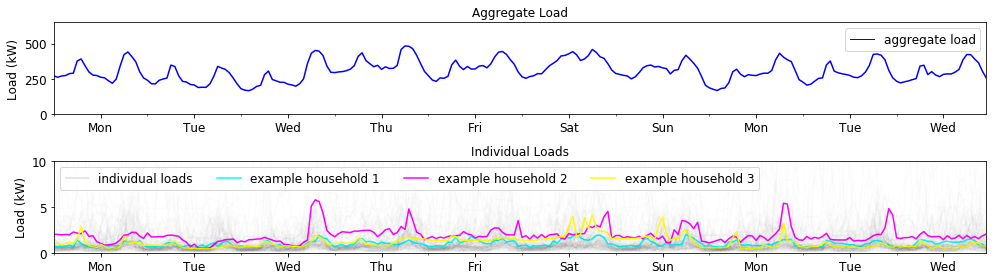

In [16]:
startPeriod = 96

fig = plt.figure(figsize = (14,4))
axs = []
#nModels = 3
window = [0,240]
plotStart, plotEnd = startPeriod+window[0], startPeriod+window[1]
titles = ['Aggregate Load', 'Individual Loads']

for j in range(2):
    axs.append(fig.add_subplot(2,1,j+1))
    
indexVals = aggLoad.index
# find the first tick
j = startPeriod+window[0]
for ind in indexVals:
    if j >= plotStart:
        if ind.hour == 0:
            startTick = 0+j
            break
    j+=1

colors = ['cyan', 'magenta', 'yellow']
colorIter = 0
lines = []

for j in range(2):
    if j == 0:
        axs[j].plot(np.arange(plotStart,plotEnd), aggLoad[plotStart:plotEnd], color='b', linestyle='-')
    elif j == 1:
        for nU in range(len(hourly_df)):
            if nU in users_to_highlight:
                line, = axs[j].plot(np.arange(plotStart,plotEnd), hourly_df.iloc[nU, plotStart:plotEnd], \
                    color=colors[colorIter], linestyle='-', alpha=1, linewidth=1.5)
                lines.append(line)
                colorIter+=1
            elif nU%2==0:
                axs[j].plot(np.arange(plotStart,plotEnd), hourly_df.iloc[nU, plotStart:plotEnd], \
                    color='k', linestyle='-', alpha=0.01)


    axs[j].set_xlim([plotStart,plotEnd-1])
    axs[j].set_title(titles[j])
    axs[j].set_xticks(np.arange(startTick,plotEnd,12), minor=True)
    axs[j].set_xticks(np.arange(startTick+12,plotEnd,24))
    tickLabs = []
    for ti in np.arange(startTick+12,plotEnd,24):
        tickLabs.append(dayLabels[indexVals[ti].dayofweek])
    axs[j].set_xticklabels(tickLabs)
    axs[j].tick_params(axis='both', labelsize=12)
    axs[j].set_ylabel('Load (kW)', fontsize=12)
axs[0].set_ylim([0,650])
axs[1].set_ylim([0,10])

lineLabels = ['individual loads','example household 1','example household 2','example household 3']
lines = []
line = mlines.Line2D([], [], color='k', label=lineLabels[0], linewidth=0.2)
lines.append(line)
for j in range(3):
    line = mlines.Line2D([], [], color=colors[j], label=lineLabels[j+1], linewidth=1.5)
    lines.append(line)

aggLine = mlines.Line2D([], [], color='blue', label='aggregate load', linewidth=1)
axs[0].legend(handles=[aggLine], fontsize=12, frameon=True)
axs[1].legend(handles=lines, ncol=4, fontsize=12, frameon=True)

fig.tight_layout()
# fig.savefig('../outputs/agg_and_ind_loads.png', dpi=300, format='png',  bbox_inches='tight')

In [17]:
userOfInterest = 6#22
startTrain = 0
endTrain = 5832
dayLoads = np.ascontiguousarray( hourly_df.iloc[userOfInterest,startTrain:endTrain].values.reshape(243,24) )
clusterLoads = np.zeros(np.shape(dayLoads))
for d, load in enumerate(dayLoads):
    if(sum(load))>0:
        clusterLoads[d,:] = load/sum(load)

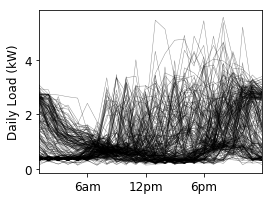

In [18]:
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
for load in dayLoads:
    ax1.plot(np.arange(1,25),load, color='k', linewidth=0.4, alpha=0.5)
    
ax1.set_ylabel('Daily Load (kW)', fontsize=12)
# ax1.set_ylim([0,6])
ax1.set_xlim([1,24])
ax1.set_xticks(np.array([6,12,18]))
ax1.set_xticklabels(['6am','12pm','6pm'])
ax1.tick_params(axis='both', labelsize=12)
# fig.savefig('../outputs/Raw.png', dpi=300, format='png',  bbox_inches='tight')

In [19]:
distance_matrix = np.zeros((24,24))
for i in range(24):
    distance_matrix[i,i:] = np.arange(0,24-i)
    if i > 0:
        a = np.arange(1,i+1)
        distance_matrix[i,0:i] = a[::-1]

In [20]:
def mydist(p1, p2, distance_matrix):
    return emd(p1,p2,distance_matrix)

In [22]:
closeness_matrix = np.zeros((len(clusterLoads),len(clusterLoads)))
for i in range(len(clusterLoads)):
    if i%100==0:
        print(i)
        sys.stdout.flush()
    for j in range(i,len(clusterLoads)):
        if i==j:
            closeness_matrix[i,j] = 0
        else:
            closeness_matrix[i,j] = mydist(clusterLoads[i], clusterLoads[j], distance_matrix)
    for j in range(i):
        closeness_matrix[i,j] = closeness_matrix[j,i]

0
100
200


In [23]:
# create the necessary distances format for hierarchical
dists = squareform(closeness_matrix)
Z = linkage(dists, "complete")
# This is the cutoff for forming the clusters
MAX_D = 2.5
cIdx = fcluster(Z, MAX_D, criterion='distance')
print('this yields', len(set(cIdx)), 'clusters')

this yields 10 clusters


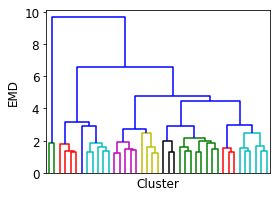

In [24]:
# look at the dendrogram, p cuts the dendrogram to show p clusters 
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
show_leaf_counts = False
ddata = dendrogram(Z,color_threshold=MAX_D,p=41,truncate_mode='lastp',show_leaf_counts=show_leaf_counts)
for i, d in zip(ddata['icoord'], ddata['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    # plt.plot(x, y, 'ro')
    #print x,y

plt.ylabel('EMD', fontsize=12)
plt.xticks([])
plt.xlabel('Cluster', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
# fig.savefig('../outputs/dendo.png', dpi=300, format='png',  bbox_inches='tight')

In [25]:
cIdx = cIdx-1
centroids = np.zeros((len(set(cIdx)),24))
for j,clusNo in enumerate(np.arange(0,len(set(cIdx)))):
    centroids[j] = np.mean(clusterLoads[np.where(cIdx==clusNo)[0],:], axis=0)

(1, 24)

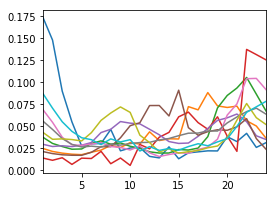

In [26]:
fig = plt.figure(figsize=(4,3))
ax1 = fig.add_subplot(111)
for centroid in centroids:
    ax1.plot(np.arange(1,25), centroid)
ax1.set_xlim([1,24])

In [27]:
counter = 0

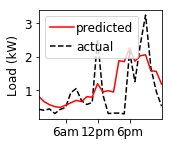

In [28]:
hrs = np.arange(1,24.1)

fig = plt.figure(figsize=(2.2,2))
ax1 = fig.add_subplot(111)
j=1
for kk,load in enumerate(dayLoads[np.where(cIdx==j)[0],:]):
    if kk == 0:
        l1, = ax1.plot(hrs, load, color = 'black', alpha=1, linestyle='--')
        break

## Create a dummy day profile and shift up or down to demo effect of scaling --> multiply by slightly different factor
l2, = ax1.plot(hrs, np.mean(dayLoads[np.where(cIdx==j)[0],:], axis=0)*1.05, color = 'r', alpha=1) 
ax1.set_xlim([1,24])
ax1.set_xticks(np.arange(6,24,6))
# ax1.set_ylim([0,4])
# ax1.set_yticks(np.arange(0,2,0.5))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_ylabel('Load (kW)', fontsize=12)
ax1.set_xticklabels(['6am','12pm','6pm'])

colorsO = ['r','k']
ls = ['-','--']
proxys = []
for k in range(2):
    proxys.append( mlines.Line2D([], [], color=colorsO[k], linestyle=ls[k]) )
    
plt.legend(proxys, ['predicted','actual'],ncol=1, fontsize=12, handletextpad=0.2, loc='upper left')

# fig.savefig('../outputs/predictedActual2.png', dpi=300, format='png',  bbox_inches='tight')

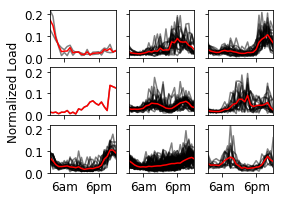

In [29]:

noR, noC = 3, 3
fig, axs = plt.subplots(noR,noC, figsize=(4,3), facecolor='w', edgecolor='k', sharex='col', sharey='row')
axs = axs.ravel()
for j in range(min(noR*noC,len(centroids))):
    for load in clusterLoads[np.where(cIdx==j)[0],:]:
        axs[j].plot(hrs, load, color = 'black', alpha=0.5) 
    axs[j].plot(hrs, centroids[j], color = 'r', alpha=1) 
    axs[j].set_xlim([1,24])
    axs[j].set_xticks(np.arange(6,24,12))
    axs[j].set_ylim([0,0.22])
    axs[j].set_yticks(np.arange(0,0.22,0.1))
    axs[j].tick_params(axis='both', labelsize=12)
axs[3].set_ylabel('Normalized Load', fontsize=12)
for j in [6,7,8]:
    axs[j].set_xticklabels(['6am','6pm'])
# fig.savefig('../outputs/clustersShapes.png', dpi=300, format='png',  bbox_inches='tight')

In [30]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
          'November', 'December']
daynum = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [31]:
# look at how these develop in time
weekdayClusters = [[] for x in range(7)]
for day in range(243):
    weekdayClusters[hourly_df.columns[day*24].dayofweek].append(cIdx[day])

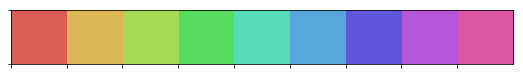

In [32]:
noColors = 9
current_palette = sns.color_palette('hls',noColors)
sns.palplot(current_palette)
dayLabels = ['Mon', 'Tue', 'Wed', 'Thu','Fri','Sat','Sun']

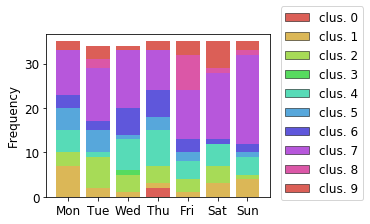

In [33]:
K = len(set(cIdx))
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
for j in range(7):
    bottom = 0
    for clus in range(K):
        clusCount = np.sum([1 for x in weekdayClusters[j] if x==clus])
        ax.bar(j,clusCount,bottom=bottom, width=0.8, color=current_palette[clus%noColors])
        bottom+=clusCount
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(dayLabels)
rects, clusLabels = [], []
for clus in range(K):
    rects.append( plt.Rectangle((0, 0), 1, 1, fc=current_palette[clus%noColors], edgecolor='black', linewidth=0.5) )
    clusLabels.append('clus. %d'%clus)
ax.legend(rects,clusLabels,loc=[1.05,-0.02], ncol=1, frameon=True, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
# fig.savefig('../outputs/clusters.png', dpi=300, format='png',  bbox_inches='tight')

In [34]:
np.unique(cIdx)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

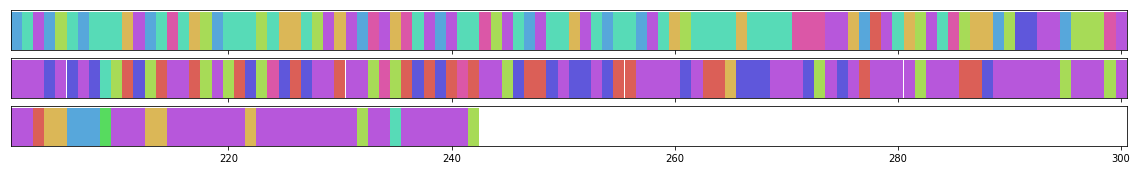

In [35]:
fig = plt.figure(figsize=(20,2.5))
ax1 = fig.add_subplot(311)
for j in range(len(cIdx)):
    color = current_palette[cIdx[j]%noColors]
    ax1.bar(j,1,color=color, width=1)
    ax1.set_xlim([.5,100.5])
    ax1.set_yticks([])
    ax1.set_xticklabels([])
    
ax1 = fig.add_subplot(312)
for j in range(len(cIdx)):
    color = current_palette[cIdx[j]%noColors]
    ax1.bar(j,1,color=color, width=1)
    ax1.set_xlim([100.5,200.5])
    ax1.set_yticks([])
    ax1.set_xticklabels([])
    
ax1 = fig.add_subplot(313)
for j in range(len(cIdx)):
    color = current_palette[cIdx[j]%noColors]
    ax1.bar(j,1,color=color, width=1)
    ax1.set_xlim([200.5,300.5])
    ax1.set_yticks([])

(168,)


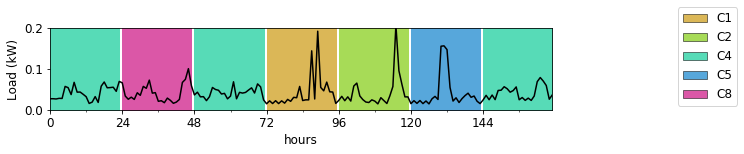

In [37]:
daysWeek = cIdx[14:21]
# print daysWeek
flattenedWeek = clusterLoads[14:21,:].flatten()
print(np.shape(flattenedWeek))
fig = plt.figure(figsize = (9,1.5))
axs = []
axs.append(fig.add_subplot(1,1,1))
axs[0].plot(np.arange(0,168),flattenedWeek, color='k')
axs[0].set_xlim([0,167])
axs[0].set_ylim([0,0.2])
for j in range(7):
    axs[0].fill_between(np.arange(24*j,(24*j+24)),0.2,color=current_palette[daysWeek[j]])
axs[0].set_xticks(np.arange(0,166,12), minor=True)
axs[0].set_xticks(np.arange(0,168,24))
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylabel('Load (kW)', fontsize=12)
axs[0].set_xlabel('hours', fontsize=12)

rects = []
colorDummies = list(set(daysWeek))
labZ = []
for j in range(len(colorDummies)):
    rects.append( plt.Rectangle((0, 0), 1, 1, fc=current_palette[colorDummies[j]], edgecolor='black', linewidth=0.5) )
    str1 = 'C%d'%(colorDummies[j])
    labZ.append(str1)
axs[0].legend(rects,labZ,loc=[1.25,0.05], ncol=1, frameon=True, fontsize=12)
# fig.savefig('../outputs/loadHistoryClusters.png', dpi=300, format='png',  bbox_inches='tight')

Text(0, 0.5, 'Load (kW)')

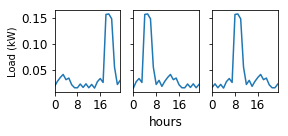

In [38]:
hrs = np.arange(1,24.1)
noR, noC = 1, 3
fig, axs = plt.subplots(noR,noC, figsize=(4,1.5), facecolor='w', edgecolor='k', sharex='col', sharey='row')
dummyDay = clusterLoads[19]
rolls = [8,18,-2]
for j in range(3):
    axs[j].plot(np.arange(0,24), np.roll(dummyDay,rolls[j]))
    axs[j].tick_params(axis='both', which='major', labelsize=12)
    axs[j].set_xticks(np.arange(0,24,8))
    axs[j].set_xlim([0,23])
axs[1].set_xlabel('hours', fontsize=12)
axs[0].set_ylabel('Load (kW)')
# fig.savefig('../outputs/demoEMD.png', dpi=300, format='png',  bbox_inches='tight')

Find the probability of a certain cluster given the day before $ P(c_{d,i}|c_{d-1,j}) $

In [39]:
###### lets make a transition matrix
pTrans = np.zeros((K,K,2))
M_F = [0,1,2,3,4]
fromDays = [[] for j in range(2)]
for j in range(len(cIdx)):
    dayStart = j*24
    if j>0:
        # get the day of the week
        dayLabel = hourly_df.columns[dayStart].dayofweek
        if dayLabel in M_F:
            if dayLabel in M_F[1:]:
                pTrans[cIdx[j-1],cIdx[j],0]+=1
                fromDays[0].append(cIdx[j-1])
            else:
                pTrans[cIdx[j-3],cIdx[j],0]+=1
                fromDays[0].append(cIdx[j-3])
        else:
            if dayLabel==5:
                pTrans[cIdx[j-6],cIdx[j],1]+=1
                fromDays[1].append(cIdx[j-6])
            else:
                pTrans[cIdx[j-1],cIdx[j],1]+=1
                fromDays[1].append(cIdx[j-1])

Visualise the transition matrix

In [40]:
for j in range(K):
    if sum(pTrans[j,:,0])>0:
        pTrans[j,:,0]=pTrans[j,:,0]/sum(pTrans[j,:,0])
    if sum(pTrans[j,:,1])>0:
        pTrans[j,:,1]=pTrans[j,:,1]/sum(pTrans[j,:,1])

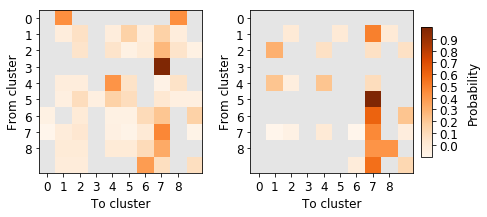

In [41]:
test = pTrans[:,:,0]
test[np.where(test==0)]=np.nan

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(121)

masked_array = np.ma.array (test, mask=np.isnan(test))
cmap = cmx.Oranges
minVal, maxVal = -0.1, 1.
cmOcc = plt.cm.get_cmap('Oranges')
cNorm = colors2.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []
cmOcc.set_bad('grey',0.2)

plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
# plt.clim
ax1.set_ylabel('From cluster', fontsize=12)
ax1.set_xlabel('To cluster', fontsize=12)
ax1.set_xticks(np.arange(0,9))
ax1.set_yticks(np.arange(0,9))
ax1.tick_params(axis='both', labelsize=12)
#fig.savefig('transMatWD.png', dpi=300, format='png',  bbox_inches='tight')
# plt.imshow(pTrans[:,:,0], cmap='Greens')

test = pTrans[:,:,1]
test[np.where(test==0)]=np.nan


ax1 = fig.add_subplot(122)

masked_array = np.ma.array (test, mask=np.isnan(test))

plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
ax1.set_ylabel('From cluster', fontsize=12)
ax1.set_xlabel('To cluster', fontsize=12)
ax1.set_xticks(np.arange(0,9))
ax1.set_yticks(np.arange(0,9))
ax1.tick_params(axis='both', labelsize=12)
plt.subplots_adjust(wspace=-0.1)

cbar_ax = plt.axes([0.85, 0.2, 0.02, 0.6])
cbar = fig.colorbar(scalarMap3, cax=cbar_ax, ticks=np.arange(0,1,0.1), orientation='vertical')
cbar_ax.tick_params(axis='both', which='major', labelsize=12)
cbar.set_label('Probability', labelpad=9, rotation=90, fontsize=12)

# fig.savefig('../outputs/transMat.png', dpi=300, format='png',  bbox_inches='tight')


In [42]:
# userOfInterest = 200
dayLoads = np.ascontiguousarray( hourly_df.iloc[userOfInterest,startTrain:endTrain].values.reshape(243,24) )

In [43]:
# plot total day consumption against temp and against previous day consumption
hourlyTemp = np.genfromtxt('../weatherData/hourlyTempCleaned.csv', delimiter=',')
dailyTemp = np.mean(hourlyTemp.reshape(365,24), axis=1)
dailyConsumption = np.sum(dayLoads, axis=1)

In [44]:
# get weekend and weekday daily temperatures
weekendConsumption, weekendTemp = [], []
weekdayConsumption, weekdayTemp = [], []
# 2015 starts on thursday
dayOfWeek = 3
for j in range(243):
    if dayOfWeek in [0,1,2,3,4]:
        weekdayConsumption.append(dailyConsumption[j])
        weekdayTemp.append(dailyTemp[j])
    else:
        weekendConsumption.append(dailyConsumption[j])
        weekendTemp.append(dailyTemp[j])
    dayOfWeek+=1
    dayOfWeek = dayOfWeek%7

In [45]:
weekendConsumption = np.asarray(weekendConsumption)
weekendTemp = np.asarray(weekendTemp)
weekdayConsumption = np.asarray(weekdayConsumption)
weekdayTemp = np.asarray(weekdayTemp)

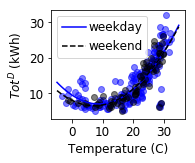

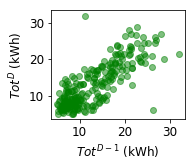

In [46]:
fig = plt.figure(figsize=(2.4,2))
ax1 = fig.add_subplot(111)

ax1.scatter(weekdayTemp, weekdayConsumption/2, marker='o', alpha=0.5, color='b')
ax1.scatter(weekendTemp, weekendConsumption/2, marker='o', alpha=0.5, color='k')
ax1.set_xlabel('Temperature (C)', fontsize=12)
ax1.set_ylabel('$Tot^D$ (kWh)', fontsize=12)

xd = np.linspace(-5,35,100)
coefsWD = poly.polyfit(weekdayTemp[weekdayConsumption<np.percentile(dailyConsumption, 99)], \
                     weekdayConsumption[weekdayConsumption<np.percentile(dailyConsumption, 99)]/2, 2)
ffit = poly.polyval(xd, coefsWD)
ax1.plot(xd, ffit, color= 'b')
coefsWE = poly.polyfit(weekendTemp[weekendConsumption<np.percentile(dailyConsumption, 99)], \
                     weekendConsumption[weekendConsumption<np.percentile(dailyConsumption, 99)]/2, 2)
ffit = poly.polyval(xd, coefsWE)
ax1.plot(xd, ffit, color='k', linestyle='--')
ax1.set_xticks(np.arange(0,31,10))
ax1.tick_params(axis='both', labelsize=12)

colorsO = ['b','k']
ls = ['-','--']
proxys = [ plt.plot([],[], marker="o", ms=8, ls="", mec=None, color=colorsO[i])[0] for i in range(2) ]
for k in range(2):
    proxys.append( mlines.Line2D([], [], color=colorsO[k], linestyle=ls[k]) )
plt.legend(proxys[2:], ['weekday','weekend'],\
           ncol=1, numpoints=1, fontsize=12, handletextpad=0.2)
# fig.savefig('TempLoad.png', dpi=300, format='png',  bbox_inches='tight')

fig = plt.figure(figsize=(2.4,2))
ax1 = fig.add_subplot(111)
ax1.scatter(dailyConsumption[:-1]/2, dailyConsumption[1:]/2, color='g', alpha=0.5)
ax1.set_xlabel('$Tot^{D-1}$ (kWh)', fontsize=12)
ax1.set_ylabel('$Tot^D$ (kWh)', fontsize=12)
ax1.tick_params(axis='both', labelsize=12)

# fig.savefig('../outputs/LoadLoad.png', dpi=300, format='png',  bbox_inches='tight')